In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments'),
    ('geolocation.csv', 'geolocation')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/91914/OneDrive/Desktop/E Commerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db= mysql.connector.connect(host="localhost",
                           username="root",
                           password="1234",
                           database="ecommerce")
cur=db.cursor()


# list all unique cities where customers are located.

In [3]:
query="""select distinct customer_city from customers """
cur.execute(query)
data=cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

# Count the number of orders placed in 2017

In [ ]:
query="""select count(order_id) from orders where year(order_purchase_timestamp)=2017 """
cur.execute(query)
data=cur.fetchall()
data

# find the total sales per category.

In [4]:
query="""select products.product_category as category,
round(sum(payments.payment_value),2) as sales
from products join order_items on products.product_id=order_items.product_id 
join payments on payments.order_id=order_items.order_id 
group by category """
cur.execute(query)
data=cur.fetchall()
data

df=pd.DataFrame(data, columns=['category', 'sales'])
df

,category,sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,Fashion Bags and Accessories,218158.28
4,bed table bath,1712553.67
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# calculate the percentage of orders that were paid in installments

In [5]:
query=""" Select (sum(case when payment_installments>=1 then 1 else 0 end))/count(*)*100 from payments"""
cur.execute(query)
data=cur.fetchall()
data

[(Decimal('99.9981'),)]

# count the number of customers from each state

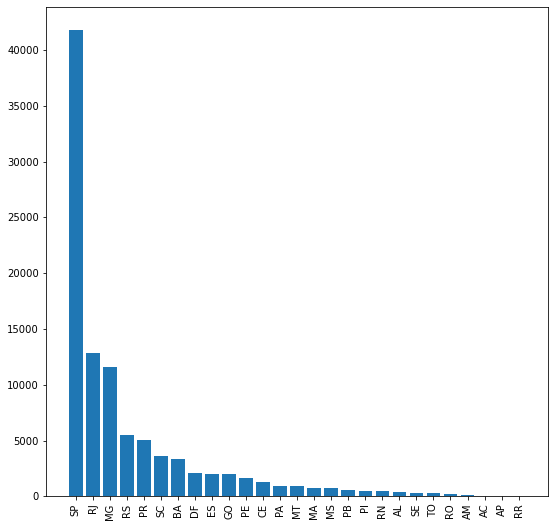

In [6]:
query="""select customer_state, count(customer_id) from customers group by customer_state"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data, columns=['State','Total Customers'])
df=df.sort_values(by="Total Customers",ascending=False)

plt.figure(figsize=(9,9))
plt.bar(df["State"],df['Total Customers'])
plt.xticks(rotation=90)
plt.show()

# calculate the number of orders per month in 2018

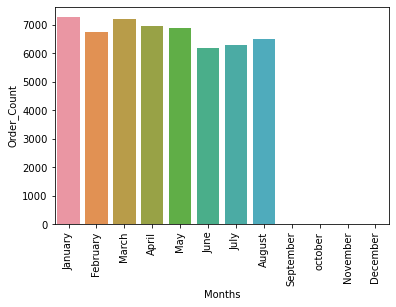

In [7]:
query="""select monthname(order_purchase_timestamp) as months,count(order_id) as count_of_orders from orders where year(order_purchase_timestamp)=2018 group by months"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['Months','Order_Count'])
o=['January','February','March','April','May','June','July','August','September','october','November','December']

ax = sns.barplot(x=df['Months'],y=df['Order_Count'],data=df,order= o)
plt.xticks(rotation = 90)

plt.show()

# find the average number of products per order,grouped by customer city.

In [8]:
query="""with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items 
on orders.order_id= order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) average_orders
from  customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns =["customer city","average orders"])
df.head(10)

,customer city,average orders
0,sao jose dos campos,1.14
1,indaial,1.12
2,treze tilias,1.27
3,sao paulo,1.16
4,rio de janeiro,1.15
5,mario campos,1.33
6,guariba,1.00
7,cuiaba,1.20
8,franca,1.25
9,tocos,1.00


# calculate the percentage of total revenue contributed by each product category.

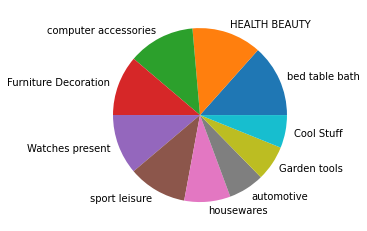

In [22]:
query="""select products.product_category as category,
round(sum(payments.payment_value)/ (select sum(payment_value) from payments) *100 , 2) as percentage
from products join order_items on products.product_id=order_items.product_id 
join payments on payments.order_id=order_items.order_id 
group by category order by percentage desc limit 10 """
cur.execute(query)
data=cur.fetchall()
data

df=pd.DataFrame(data, columns=['category', 'percentage'])
pt= df.head(10)
plt.pie(df['percentage'], labels= df['category'])
plt.show()

# Identify the correlation between product price and the number of times a product has been purchased 

In [48]:
import numpy as np
query="""select count(order_items.product_id) as count, products.product_category, round(avg(order_items.price),2)
from order_items join products on products.product_id=order_items.product_id
group by products.product_category  
order by count desc limit 10 """
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data, columns=['count', 'product_category','price'])
df.head(10)
arr1=df["count"]
arr2=df["price"]
np.corrcoef([arr1,arr2])
#ans=sns.barplot(x=df['count'],y=df['product_category'],data=df)
#plt.show()

array([[ 1.        , -0.16020024],
       [-0.16020024,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue.

In [55]:
query="""select * , dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id as seller, sum(payments.payment_value) as revenue
from order_items join payments on order_items.order_id=payments.order_id
group by seller)as a"""
cur.execute(query)
data=cur.fetchall()
data
#df=pd.DataFrame(data, columns=['seller', 'revenue'])
#df.head(10)

[('7c67e1448b00f6e969d365cea6b010ab', 507166.9073021412, 1),
 ('1025f0e2d44d7041d6cf58b6550e0bfa', 308222.0398402214, 2),
 ('4a3ca9315b744ce9f8e9374361493884', 301245.26976528764, 3),
 ('1f50f920176fa81dab994f9023523100', 290253.42012761533, 4),
 ('53243585a1d6dc2643021fd1853d8905', 284903.0804977417, 5),
 ('da8622b14eb17ae2831f4ac5b9dab84a', 272219.31931465864, 6),
 ('4869f7a5dfa277a7dca6462dcf3b52b2', 264166.1209387779, 7),
 ('955fee9216a65b617aa5c0531780ce60', 236322.30050226487, 8),
 ('fa1c13f2614d7b5c4749cbc52fecda94', 206513.22986984253, 9),
 ('7e93a43ef30c4f03f38b393420bc753a', 185134.20970630646, 10),
 ('6560211a19b47992c3666cc44a7e94c0', 179657.74904833734, 11),
 ('7a67c85e85bb2ce8582c35f2203ad736', 169030.80002561212, 12),
 ('25c5c91f63607446a97b143d2d535d31', 160534.7397725582, 13),
 ('a1043bafd471dff536d0c462352beb48', 154356.91018915176, 14),
 ('46dc3b2cc0980fb8ec44634e21d2718e', 148864.3400707245, 15),
 ('b37c4c02bda3161a7546a4e6d222d5b2', 145319.04013061523, 16),
 ('620c